## Install Dependencies

In [0]:
%pip install paddlepaddle-gpu
%pip install paddleocr

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
from paddleocr import PaddleOCR,draw_ocr

/local_disk0/.ephemeral_nfs/envs/pythonEnv-ff5bc0fe-3494-4132-a9cb-5f41f9b83636/lib/python3.11/site-packages/paddle/base/framework.py:688: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


## Run the paddle OCR cod

In [0]:
import paddle
import requests
import io
import cv2
import time
from PIL import Image
import numpy as np
import pandas as pd
from paddleocr import PaddleOCR

In [0]:
# Change to your configuration
catalog_name = "kyra_wulffert"
schema_name = "vision"

In [0]:
pddl_ocr = PaddleOCR(lang='en', use_gpu=False)

[2025/05/16 12:31:33] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

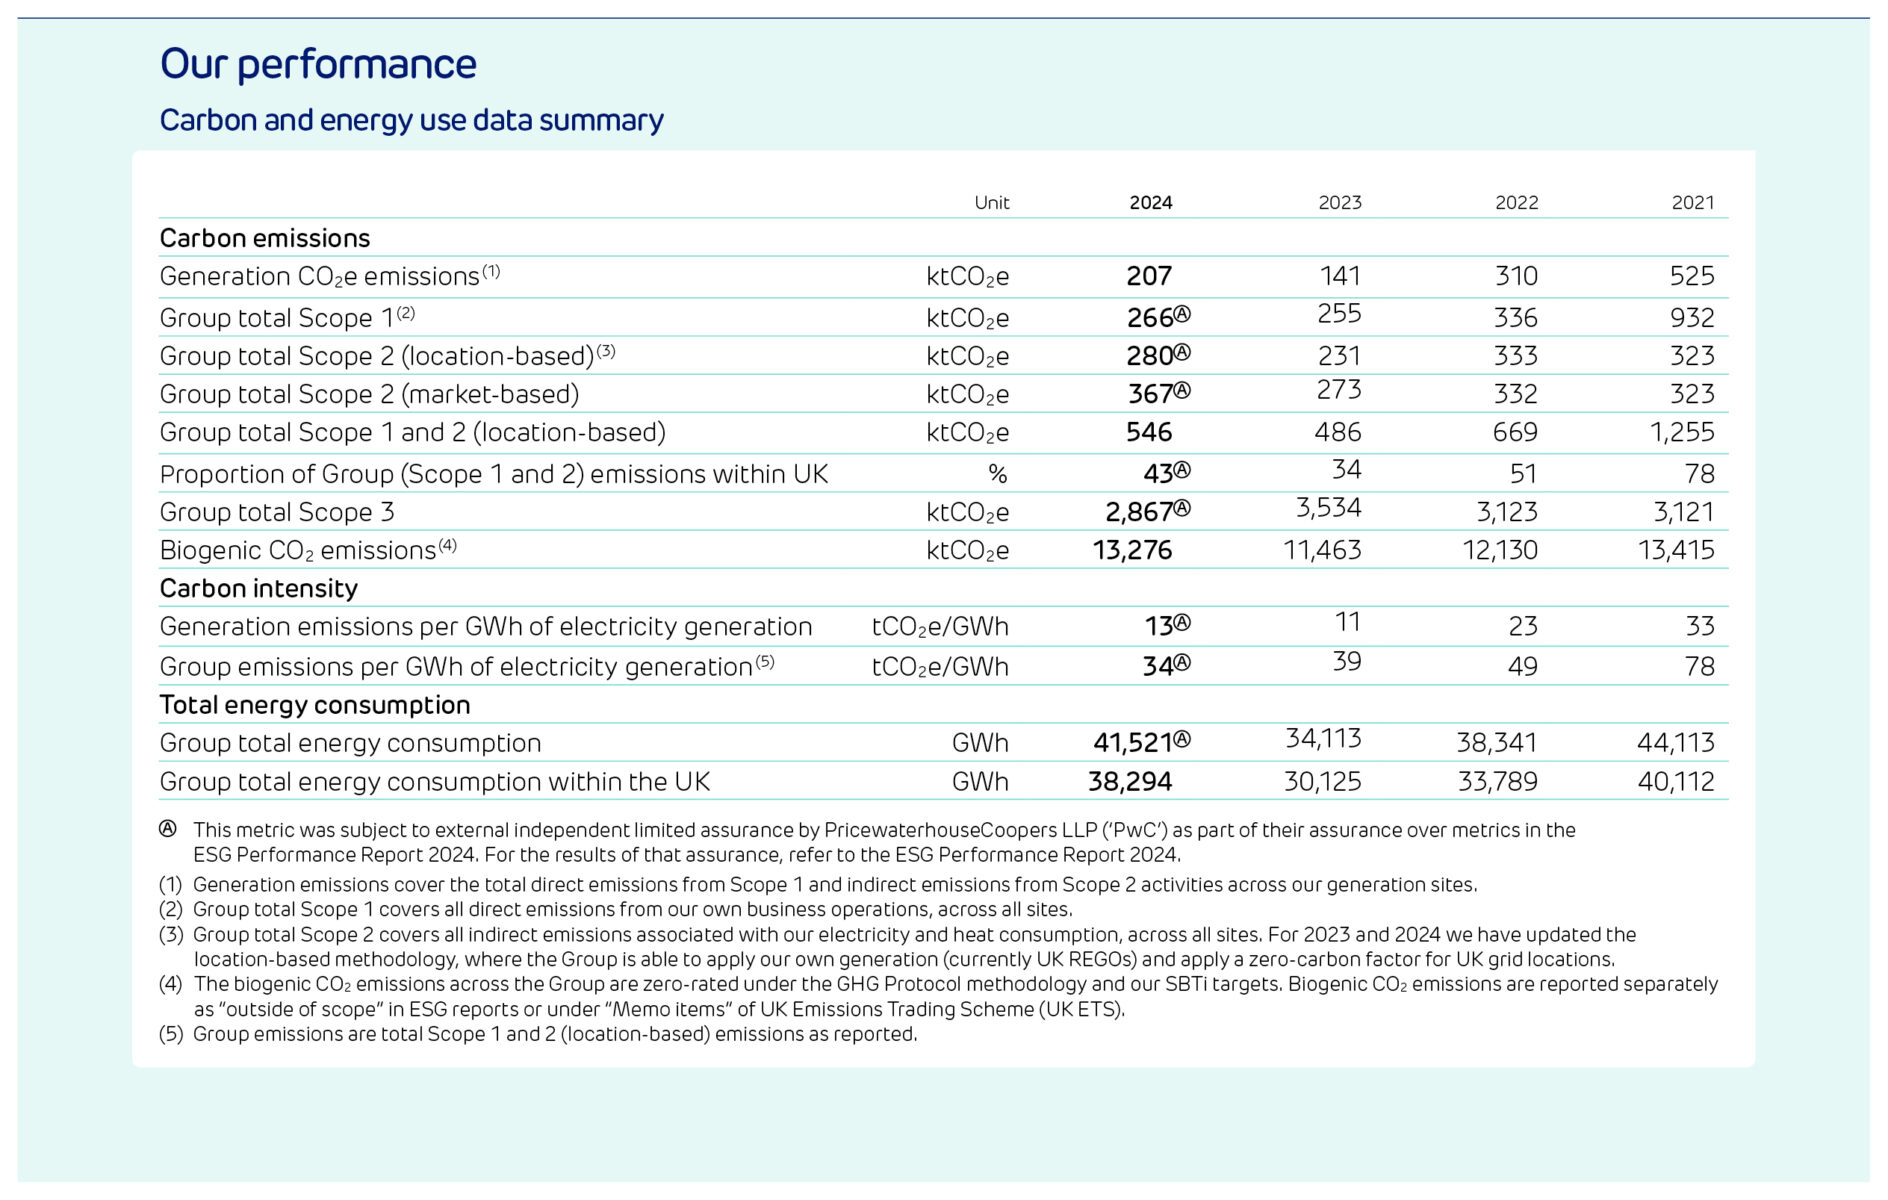

In [0]:
# Change to the path of your image
link = '/Volumes/kyra_wulffert/vision/web_images/Drax_AR2024_Page_38_Carbon_Emissions_Summary-1888x1200.jpg'
image = Image.open(link)
np_img = np.array(image)
image

In [0]:
result = pddl_ocr.ocr(np_img, cls=False)
result

[2025/05/16 12:31:35] ppocr DEBUG: dt_boxes num : 91, elapsed : 0.307034969329834
[2025/05/16 12:31:41] ppocr DEBUG: rec_res num  : 91, elapsed : 6.203104496002197


[[[[[161.0, 47.0], [474.0, 47.0], [474.0, 81.0], [161.0, 81.0]],
   ('Our performance', 0.9640096426010132)],
  [[[161.0, 107.0], [663.0, 107.0], [663.0, 134.0], [161.0, 134.0]],
   ('Carbon and energy use data summary', 0.94093257188797)],
  [[[972.0, 189.0], [1015.0, 189.0], [1015.0, 213.0], [972.0, 213.0]],
   ('Unit', 0.998190701007843)],
  [[[1127.0, 189.0], [1176.0, 189.0], [1176.0, 213.0], [1127.0, 213.0]],
   ('2024', 0.9993221759796143)],
  [[[1316.0, 189.0], [1365.0, 189.0], [1365.0, 213.0], [1316.0, 213.0]],
   ('2023', 0.9994015693664551)],
  [[[1491.0, 186.0], [1546.0, 186.0], [1546.0, 215.0], [1491.0, 215.0]],
   ('2022', 0.9993162155151367)],
  [[[1670.0, 189.0], [1719.0, 189.0], [1719.0, 213.0], [1670.0, 213.0]],
   ('2021', 0.9988760352134705)],
  [[[158.0, 221.0], [374.0, 225.0], [373.0, 253.0], [157.0, 249.0]],
   ('Carbon emissions', 0.995316743850708)],
  [[[157.0, 263.0], [503.0, 260.0], [504.0, 288.0], [157.0, 290.0]],
   ('Generation COe emissions(1)', 0.9884150

In [0]:
import mlflow
from mlflow.pyfunc import PythonModel
import torch

In [0]:
class CustomPaddleOCRModel(PythonModel):
    from paddleocr import PaddleOCR
    import numpy as np
    import requests
    import pandas as pd
    import io
    from PIL import Image
    from time import time
    import paddle
    import torch

    def __init__(self):
        super().__init__()

    def load_context(self, context):
        #self.is_gpu = torch.cuda.is_available()
        #paddle.utils.run_check()
        self.paddleocr = PaddleOCR(lang='en', use_gpu=False)

    def _preprocess(self, link):
        # response = requests.get(link)
        image = Image.open(link)
        np_img = np.array(image)
        return np_img
    
    def get_paddleocr_text(self, np_arry):
        result = self.paddleocr.ocr(np_arry, cls=False)
        output = []
        for idx in range(len(result)):
            res = result[idx]
            for line in res:
                output.append(line[1][0])
        output = ' '.join(output)
        return output  
    
    def predict(self, context, input_data):
        ocr_text_list=[]
        for item in range(0,len(input_data)):
            np_image = self._preprocess(input_data['image_link'][item])
            ocr_text = self.get_paddleocr_text(np_image)
            ocr_text_list.append(ocr_text)

        return pd.DataFrame({"ocr_text":ocr_text_list})


In [0]:
custom_ocr = CustomPaddleOCRModel()

In [0]:
from mlflow.models.signature import ModelSignature, infer_signature
from mlflow.types import DataType, Schema, ColSpec

# Change to the path of your image
link = '/Volumes/kyra_wulffert/vision/web_images/Drax_AR2024_Page_38_Carbon_Emissions_Summary-1888x1200.jpg'
input_data = pd.DataFrame({'image_link':[link]})
# print(input_data)
custom_ocr.load_context(None)
output_data = custom_ocr.predict(None, input_data)

[2025/05/16 12:31:41] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [0]:
ocr_signature = infer_signature(input_data, output_data)


In [0]:
#pip_requirements = [f'numpy=={np.__version__}','paddlepaddle-gpu==2.5.1','paddleocr','cudatoolkit==11.7','torch==1.13.1']

pip_requirements = [f'numpy=={np.__version__}','paddleocr','torch==1.13.1']
default_conda_env = mlflow.pyfunc.get_default_conda_env()
default_conda_env['channels'].append("https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/Paddle/")
#default_conda_env['dependencies'].append('cudatoolkit=11.7')
default_conda_env['dependencies'][2]['pip'].append(f'numpy=={np.__version__}')
default_conda_env['dependencies'][2]['pip'].append('torch==1.13.1')
#default_conda_env['dependencies'][2]['pip'].append('paddlepaddle-gpu==2.5.1')
default_conda_env['dependencies'][2]['pip'].append('paddleocr')
default_conda_env

{'name': 'mlflow-env',
 'channels': ['conda-forge',
  'https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/Paddle/'],
 'dependencies': ['python=3.11.11',
  'pip<=23.2.1',
  {'pip': ['mlflow==2.19.0',
    'cloudpickle==2.2.1',
    'numpy==1.26.4',
    'torch==1.13.1',
    'paddleocr']}]}

In [0]:
with mlflow.start_run(run_name="web_image") as run:
    mlflow.pyfunc.log_model(
            "model",
            python_model=CustomPaddleOCRModel(),
            input_example=input_data,
            signature=ocr_signature,
            conda_env=default_conda_env)

2025/05/16 12:31:53 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.3.1+cpu, required: torch==1.13.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/05/16 12:31:53 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.3.1+cpu, required: torch==1.13.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[2025/05/16 12:31:53] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

🏃 View run web_image at: https://adb-984752964297111.11.azuredatabricks.net/ml/experiments/eee0e77317ae41a784ea3ce713948c33/runs/42ebde99da7143099310d25be94fad4c
🧪 View experiment at: https://adb-984752964297111.11.azuredatabricks.net/ml/experiments/eee0e77317ae41a784ea3ce713948c33


In [0]:
logged_model_uri = f"runs:/{run.info.run_id}/model"

In [0]:
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run.info.run_id}/model")

2025/05/16 12:32:26 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.3.1+cpu, required: torch==1.13.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[2025/05/16 12:32:26] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [0]:
loaded_model.predict(input_data)

[2025/05/16 12:32:28] ppocr DEBUG: dt_boxes num : 91, elapsed : 0.19004559516906738
[2025/05/16 12:32:35] ppocr DEBUG: rec_res num  : 91, elapsed : 7.300289869308472


,ocr_text
0,Our performance Carbon and energy use data sum...


In [0]:
mlflow.set_registry_uri('databricks-uc')
model_name = "OCRModel" 
UC_MODEL_NAME = f"{catalog_name}.{schema_name}.{model_name}"

uc_registered_model_info = mlflow.register_model(model_uri=logged_model_uri, name=UC_MODEL_NAME)

Registered model 'kyra_wulffert.vision.OCRModel' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

Created version '2' of model 'kyra_wulffert.vision.ocrmodel'.


In [0]:
model_name = f"{catalog_name}.{schema_name}.{model_name}"
model_version = "1"
model_uri = f"models:/{model_name}/{model_version}" 
loaded_model = mlflow.pyfunc.load_model(model_uri)

2025/05/16 12:32:43 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - torch (current: 2.3.1+cpu, required: torch==1.13.1)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[2025/05/16 12:32:43] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [0]:
pd.set_option('display.max_colwidth', None)
loaded_model.predict(input_data)

[2025/05/16 12:32:46] ppocr DEBUG: dt_boxes num : 91, elapsed : 0.22432565689086914
[2025/05/16 12:32:54] ppocr DEBUG: rec_res num  : 91, elapsed : 8.557824611663818


,ocr_text
0,"Our performance Carbon and energy use data summary Unit 2024 2023 2022 2021 Carbon emissions Generation COe emissions(1) ktCO2e 207 141 310 525 Group total Scope 1(2) ktCO2e 2660 255 336 932 Group total Scope 2 (location-based)(3) ktCOe 280 231 333 323 Group total Scope 2 (market-based) ktCOe 3670 273 332 323 Group total Scope1 and 2 (location-based) ktCO2e 546 486 669 1,255 % 43 34 Proportion of Group (Scope 1 and 2) emissions within UK 51 78 Group total Scope 3 ktCOe 2,867 3,534 3,123 3,121 Biogenic CO emissions(4) ktCO2e 13,276 11,463 12,130 13,415 Carbon intensity Generation emissions per Gwh of electricity generation tCOe/GWh 13 11 23 33 Group emissions per GWh of electricity generation(5) tCOe/GWh 340 39 49 78 Total energy consumption Group total energy consumption GWh 41,521 34,113 38,341 44,113 Group total energy consumption within the UK GWh 38,294 30,125 33,789 40,112 This metric was subject to external independent limited assurance by PricewaterhouseCoopers LLP (PwC) as part of their assurance over metrics in the ESG Performance Report 2024.For the results of that assurance,refer to the ESG Performance Report 2024. (1) Generation emissions cover the total direct emissions from Scope 1 and indirect emissions from Scope 2 activities across our generation sites. (2) Group total Scope 1 covers all direct emissions from our own business operations,across all sites. (3) Group total Scope 2 covers all indirect emissions associated with our electricity and heat consumption, across all sites.For 2023 and2024 we have updated the location-based methodology,where the Group is able to apply our own generation (currently UK REGOs) and apply a zero-carbon factor for UK grid locations. (4) The biogenic CO emissions across the Group are zero-rated under the GHG Protocol methodology and our SBTi targets.Biogenic CO emissions are reported separately as""outside of scope""in ESG reports or under""Memo items"" of UK Emissions Trading Scheme (UK ETS). (5) Group emissions are total Scope 1 and2 location-based) emissions as reported."


Apply the modle to the bacth of data

In [0]:
from pyspark.sql.functions import input_file_name, regexp_replace

images_location = "/Volumes/kyra_wulffert/vision/web_images/"
df = spark.read.format("image").load("/Volumes/kyra_wulffert/vision/web_images/")
df = df.withColumn("image_link", input_file_name())
df = df.withColumn("image_link", regexp_replace("image_link", "dbfs:", ""))
input_data = df.toPandas()
custom_ocr.load_context(None)
output_data = custom_ocr.predict(None, input_data)
input_data['ocr_text'] = output_data


[2025/05/16 12:32:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

In [0]:
spark_df = spark.createDataFrame(input_data)
spark_df.write.format("delta").mode("overwrite").option("mergeSchema", "true").saveAsTable(f"{catalog_name}.{schema_name}.ocr_clean_data")


In [0]:
spark_df.show()

+--------------------+--------------------+--------------------+
|               image|          image_link|            ocr_text|
+--------------------+--------------------+--------------------+
|{[FF FF FF FF FF ...|/Volumes/kyra_wul...|Our performance C...|
+--------------------+--------------------+--------------------+

